In [1]:
# 查看当前挂载的数据集目录
!ls /home/kesci/input/

mobile5497


In [2]:
# # 查看当前kernel下的package
# !pip list --format=columns

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
# import lightgbm as lgb
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import collections
import matplotlib.pyplot as plt

In [4]:
# 注意该段代码，如何将行的项变换到列上，虽然有点笨！
tmp = pd.DataFrame({'a':[1, 2, 2, 1, 2], 'b':[3, 3, 3, 3, 5], 'c':np.arange(5, 10)})
tmp = pd.DataFrame({'a':[1, 2, 2, 1, 2], 'b':[3, 3, 3, 3, 5], 'c':np.arange(5, 10)})
def f(x):
    for i in range(5, 10):
        if x['c'].apply(lambda x: x == i).any():
            x[str(i)] = i * 10
        else:
            x[str(i)] = 0 
    # x['h'] = sum(x['c'])
    # x['hh'] = x.iloc[0]['c']
    return x
tmp.groupby(['a', 'b']).apply(f)

,a,b,c,5,6,7,8,9
0,1,3,5,50,0,0,80,0
1,2,3,6,0,60,70,0,0
2,2,3,7,0,60,70,0,0
3,1,3,8,50,0,0,80,0
4,2,5,9,0,0,0,0,90


In [2]:
path = '/home/kesci/input/mobile5497/china-mobile-user-gemographics/'
app_events = pd.read_csv(path + 'app_events.csv')
app_labels = pd.read_csv(path + 'app_labels.csv')
events = pd.read_csv(path + 'events.csv')

gender_age_test = pd.read_csv(path + 'gender_age_test.csv')
gender_age_train = pd.read_csv(path + 'gender_age_train.csv')

label_categories = pd.read_csv(path + 'label_categories.csv')

phone_brand_device_model = pd.read_csv(path + 'phone_brand_device_model.csv')

In [12]:
p1 = '/home/kesci/work/app_exist1.csv'
p2 = '/home/kesci/work/eu1.csv'
if os.path.exists(p1):
    app_exist1 = pd.read_csv(p1)
if os.path.exists(p2):
    events_uniq1 = pd.read_csv(p2)

**events数据中含有其他国家地区的用户情况，我们这里主要探索中国及其邻近地区的移动用户情况**

In [13]:
events_cn = events[(events['longitude'] >= 73.5) & (events['longitude'] <= 135.2) &
(events['latitude'] >= 20.2) & (events['latitude'] <= 53.5) ]
print('位于国内的记录占比：', events_cn.shape[0] / events.shape[0])

位于国内的记录占比： 0.6736227116924638


In [14]:
del events
gc.collect()

750

# 1.观察不同应用类型的安装次数以及使用次数

In [15]:
# 为提高效率，不采样merge，而是采用map映射字典来关联不同数据集之间的信息
dic_a2l = dict(zip(app_labels['app_id'], app_labels['label_id']))
dic_l2c = dict(zip(label_categories['label_id'], label_categories['category']))
dic_e2d = dict(zip(events_cn['event_id'], events_cn['device_id']))

app_events['label_id'] = app_events['app_id'].map(dic_a2l)
app_events['category'] = app_events['label_id'].map(dic_l2c)
app_events['device_id'] = app_events['event_id'].map(dic_e2d)

# 安装次数
duniq = app_events.drop_duplicates(subset=['device_id', 'category'])
ct_vc_duniq = duniq['category'].value_counts(normalize=True)
# 使用次数
ct_vc = app_events['category'].value_counts(normalize=True)

In [16]:
ct1 = ct_vc_duniq[:20]
ct2 = ct_vc[:20]
r1, r2 = [], []
for c in ct1.index:
    if ct1[c] / ct_vc[c] < 0.3:
        r1.append(c)
for c in ct2.index:
    if ct2[c] / ct_vc_duniq[c] >= 1.2:
        r2.append(c)
print('安装最多的应用类型：')
print(ct1, '\n')
print('使用最多的应用类型：')
print(ct2,'\n')
print('用户非常活跃的应用类型：')
print(r2)

安装最多的应用类型：
IM                                        0.043398
Industry tag                              0.042418
Pay                                       0.039416
video                                     0.038865
online malls                              0.037271
unknown                                   0.036029
Property Industry 1.0                     0.031519
P2P net loan                              0.031412
music                                     0.031132
And the Church                            0.027719
map                                       0.027669
online shopping by group, like groupon    0.023202
Property Industry 2.0                     0.023148
Internet Banking                          0.021257
weibo                                     0.019038
pictures photography                      0.017531
community                                 0.017066
Consumer Finance                          0.016825
Technology Information                    0.016193
reading platform    

探索小结：对比应用的安装以及使用情况，可以看到用户使用的应用主要集中在支付购物，娱乐社交，出行以及金融借贷，和日常生活经验相符。
值得关注的是以p2p 借贷为代表的金融工具使用频率非常高。

# 2.对于使用高频的应用类型，我们探索不同用户群组的使用习惯
我将一天分为4个时间段，探索用户每天各个时间段对这些高频应用的使用情况

event数据集中记录了用户一天之内触发的若干个event。，而每次event中app的使用情况则由app_event数据集记录，我们需要将app_event数据集的信息整理后和event数据集进行关联

In [12]:
# events数据的时间处理
events_cn['ts'] = pd.to_datetime(events_cn['timestamp'])
events_cn['hour'] = events_cn['ts'].dt.hour
# 将一天分为凌晨以及早中晚4个部分
dic_h2g = {}
for i in range(24):
    if i < 6:
        dic_h2g[i] = 0
    elif i < 12:
        dic_h2g[i] = 1
    elif i < 18:
        dic_h2g[i] = 2
    else:
        dic_h2g[i] = 3
events_cn['hg'] = events_cn['hour'].map(dic_h2g)

In [10]:
# app_event数据集聚合
app_events_cn = app_events.dropna()
def grouplist(df, gr, col):
    tmp=df.groupby(gr).agg({col: list}).reset_index()
    return tmp
app_events_cn_list = grouplist(app_events_cn, 'event_id', 'category')
# event数据集关联以上app_event的聚合信息
dic_cts = dict(zip(app_events_cn_list['event_id'], 
app_events_cn_list['category']))
events_cn['cts'] = events_cn['event_id'].map(dic_cts)

# 根据不同的时间段继续对event进行分组，以便之后的分组统计
events_cn_notnan = events_cn.dropna()
events_cn_nn_list = grouplist(events_cn_notnan, ['device_id', 'hg'], 'cts')
# 设置新的一列，以字典的形式记录每个device各个时间段的app使用情况
def cts_num(lists):
    res = []
    for lis in lists:
        res.extend(lis)
    return collections.Counter(res)
events_cn_nn_list['cts_num'] = events_cn_nn_list['cts'].apply(cts_num)
# 统计受欢迎的app每个时间段的使用情况
# ct2是使用最多的app
def popular_apps(c):
    apps = ct2.index.tolist()
    return {k:c[k] for k in c if k in apps}
events_cn_nn_list['popular_cts_num'] = events_cn_nn_list['cts_num'].apply(popular_apps)
# 将字典形式的cts_num列转为多个列，更加易于统计
hg = events_cn_nn_list.hg.nuniqe()
def appused_eachtime(df, r = hg):
    for i in range(r):
        tmp = df[df['hg'] == i]['popular_cts_num'].values
        if tmp.size:
            for k in tmp[0]:
        
                df['hg_' + str(i) + '_' + k] = tmp[0][k]
    return df

events_cn_nn_columns = events_cn_nn_list.groupby('device_id', 
sort = True).apply(appused_eachtime)            
events_uniq = events_cn_nn_columns.drop_duplicates(subset=['device_id'])
events_uniq.fillna(0, inplace=True)

In [145]:
# 计算每个应用一天各个时间段的平均使用次数
events_cn_notnan['dg'] = events_cn_notnan['ts'].dt.day
events_dg1 = events_cn_notnan.groupby(['device_id', 'dg'])['ts'].count().reset_index()
events_dg2 = events_dg1.groupby(['device_id'])['dg'].count().reset_index()
events_uniq1 = events_uniq.merge(events_dg2, on='device_id', how='left')
hgs = [c for c in events_uniq1.columns if 'hg_' in c]
for c in hgs:
    events_uniq1[c] = events_uniq1[c] / events_uniq1['dg']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [146]:
# 关联训练集标签
events_uniq1 = events_uniq1.merge(gender_age_train, on = 'device_id', how='left')

F23- : 919.7404761904762


<Figure size 432x288 with 1 Axes>
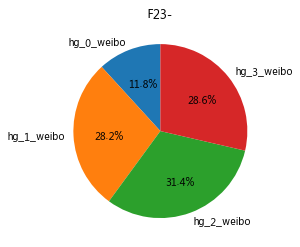

F24-26 : 641.1595238095238


<Figure size 432x288 with 1 Axes>
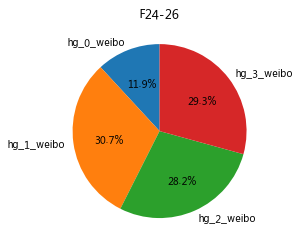

F27-28 : 485.2452380952381


<Figure size 432x288 with 1 Axes>
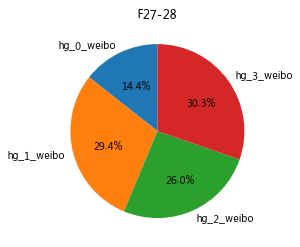

F29-32 : 542.8214285714286


<Figure size 432x288 with 1 Axes>
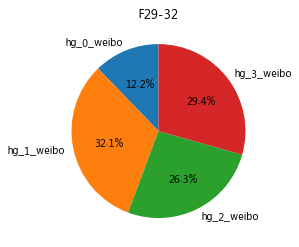

F33-42 : 604.8404761904762


<Figure size 432x288 with 1 Axes>
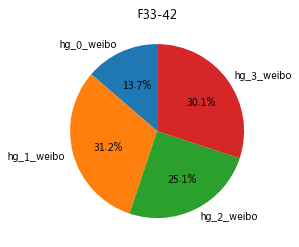

F43+ : 392.6285714285714


<Figure size 432x288 with 1 Axes>
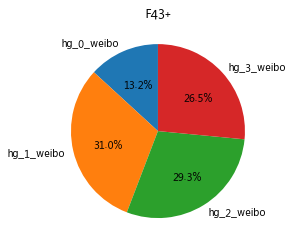

M22- : 1592.2059523809523


<Figure size 432x288 with 1 Axes>
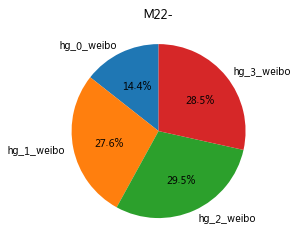

M23-26 : 2214.508333333333


<Figure size 432x288 with 1 Axes>
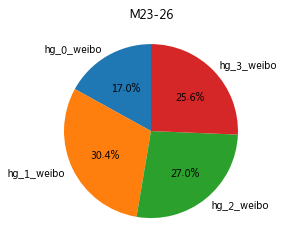

M27-28 : 1528.0833333333333


<Figure size 432x288 with 1 Axes>
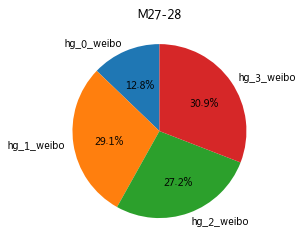

M29-31 : 1922.1904761904761


<Figure size 432x288 with 1 Axes>
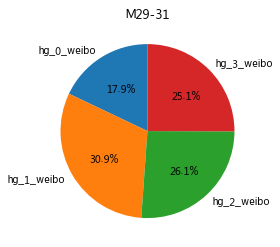

M32-38 : 2231.2976190476193


<Figure size 432x288 with 1 Axes>
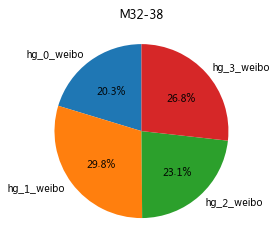

M39+ : 1482.5142857142857


<Figure size 432x288 with 1 Axes>
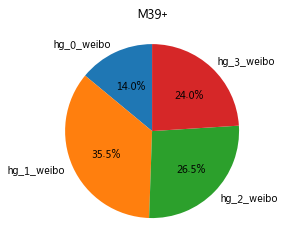

In [27]:

# 查看一下不同group的同一应用每天的使用次数
def group_app_count(gr1, app):
    sizes, labels = [], []
    df1 = events_uniq1[events_uniq1['group'] == gr1]
    
    for i in range(4):
        k = 'hg_' + str(i) + '_' + app
        sizes.append(df1[k].sum())
        labels.append(k)
    print(gr1, ':', sum(sizes))
    plt.pie(sizes, labels = labels,  autopct='%1.1f%%', startangle=90)
    plt.title(gr1)
    plt.show()
# 我们以常见的应用类型Technology Information为例，看看不同人群的使用次数以及每天的使用情况
for g in sorted(events_uniq1.dropna().group.unique()):
    group_app_count(g, 'weibo')

探索小结：对于高频使用的应用，不同人群的使用情况存在不小的差异。我们以weibo为例，女性更喜欢在下午和晚上使用，而中青年男性在凌晨使用的频率远高于其他人群

# 3.探索不常用的应用在各个人群的表现情况

In [184]:
for ct in rare_cts:
    events_uniq1['exist_' + ct] = events_uniq1['cts_num'].apply(lambda x: ct in x)

In [192]:
app_exist = grouplist(events_cn_notnan, 'device_id', 'cts')
def dl2s(lists):
    res = []
    for lis in lists:
        res.extend(lis)
    return set(res)
app_exist['set_cts'] = app_exist['cts'].apply(dl2s)

In [19]:
# events_uniq2 = events_uniq1.dropna()
rare_cts = ct_vc.index[20:100]
for ct in rare_cts:
    app_exist[ct] = app_exist['set_cts'].apply(lambda x: int(ct in x))

In [201]:
app_exist1 = app_exist.merge(gender_age_train, on='device_id', how='left')

对于并不常用的应用，为了避免数据过于稀疏，需要在非常用应用中选出能较好分辨不同人群的应用。如果某个应用在某一人群中的安装频率明显高于或者低于总体水平，则这个应用具有帮助分辨人群的价值。

In [29]:
valued_rc = {}
grs = events_uniq1.dropna().group.unique().tolist()
for ct in rare_cts:
    if ct not in app_exist1.columns:
        continue
    df = app_exist1[app_exist1[ct] == 1]
    sp = df.shape[0]
    for gr in grs:
        tmp = df[df['group'] == gr]
        r = tmp.shape[0] / sp
        if r > 0.1 or r < 0.01:
            valued_rc[ct] = [gr, r]
            break
len(valued_rc)

33

以下为具有分辨价值的非常用的应用。我们可以发现，游戏和汽车类应用对于年轻女性缺乏吸引力，而保险和儿童教育不是年轻男性的菜

In [30]:
valued_rc

{'Custom label': ['F23-', 0.007642055959571059],
 'Car Owners': ['F23-', 0.0069387755102040816],
 'Third-party card management': ['F29-32', 0.009206913261185593],
 'Property Industry new': ['F24-26', 0.009976617303195635],
 'mobile bank': ['F23-', 0.008082064034815045],
 'Bank Credit Card': ['F23-', 0.006203007518796992],
 'Securities': ['F23-', 0.004921004921004921],
 'Traditional securities brokerage': ['M22-', 0.009654471544715448],
 'Internet banking': ['F27-28', 0.008912294915940856],
 'Direct Banking': ['F23-', 0.0061667488899852],
 'Internet Securities': ['F23-', 0.007679180887372013],
 'the film': ['F43+', 0.009702241552358649],
 'Financial Information': ['F23-', 0.004892367906066536],
 'Wealth Management': ['F27-28', 0.008557457212713936],
 'fund': ['F23-', 0.006241640659830584],
 'Lottery ticket': ['F23-', 0.0066518847006651885],
 'Appliances': ['F23-', 0.007882882882882882],
 'Prepare pregnant pregnancy': ['M22-', 0.009248554913294798],
 'convenience services': ['F23-', 0.00

In [210]:
# app_exist1[[c for c in app_exist1.columns if 'cts' not in c]].to_csv('app_exist1.csv', index=False)
# events_uniq1[[c for c in events_uniq1.columns if 'cts' not in c]].to_csv('eu1.csv', index=False)

# 4.不同手机品牌的人群使用情况

In [32]:
# 选取最受欢迎的10个品牌
brand_candis = phone_brand_device_model.phone_brand.value_counts(normalize=True).index[:10].tolist()

In [34]:
dic_d2b = dict(zip(phone_brand_device_model['device_id'], phone_brand_device_model['phone_brand']))
gender_age_train['phone_brand'] = gender_age_train['device_id'].map(dic_d2b)

In [56]:
tmp = gender_age_train
tmp = tmp[tmp['phone_brand'].apply(lambda x: x in brand_candis)]

<Figure size 864x576 with 1 Axes>
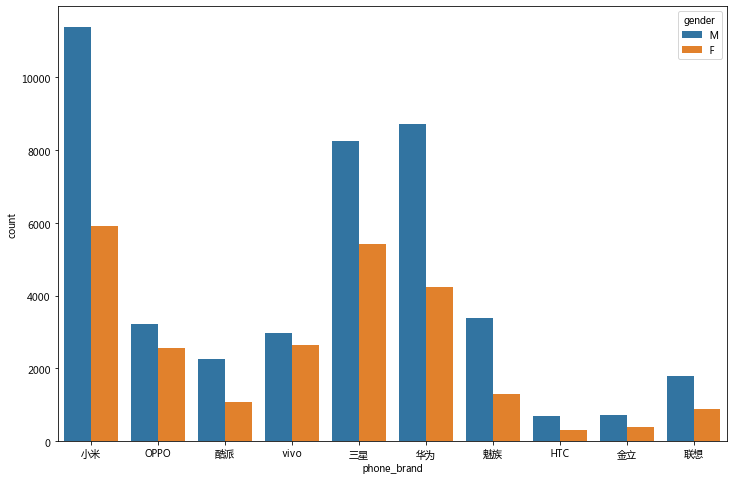

In [60]:
plt.figure(figsize=(12, 8))
sns.countplot(x='phone_brand', hue='gender', data=tmp)
plt.show()

探索小结：小米和华为的男性客户非常多，而主打音乐和摄像的手机品牌，以vivo和oppo为例，则吸引了很多女性用户

# 5.模型预测
采用xgboost，考察在加入上述特征后，模型对于人群的刻画能力

In [79]:
events_uniq1.drop(['hg', 'dg'], axis=1, inplace=True)
app_exist1.drop(['gender', 'age', 'group'], axis=1, inplace=True)
eu2 = events_uniq1.merge(app_exist1, on='device_id', how='left')
brand = phone_brand_device_model[['device_id', 'phone_brand']]
brand_dum = pd.get_dummies(data=brand, columns=['phone_brand'])
eu3 = eu2.merge(brand_dum, on='device_id', how='left')
eu4 = eu3.dropna()

In [12]:
dic_g2i = dict(zip(sorted(eu4.group.unique()), range(eu4.group.nunique())))
eu4['group'] = eu4['group'].map(dic_g2i)

In [83]:
eu4['gender'] = eu4['gender'].apply(lambda x: 1 if x == 'M' else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
def xgbclf(train, test, init_cols, label='group'):
    res = 0
    trainproba = np.zeros(len(train))
    pred = np.zeros(len(test))
    Xy_train = train[init_cols+[label]]
    X_test = test[init_cols]

    y_train = train[label]
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        objective='multi:softmax',
        num_class=train.group.nunique(),
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='mlogloss',
        # tree_method='gpu_hist' 
    )

    folds = KFold(n_splits=5, shuffle=True, random_state=2020)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(Xy_train)):
        # print("fold {}:".format(fold_ + 1))
        xytrain = Xy_train.iloc[trn_idx]
        xyval = Xy_train.iloc[val_idx] 
        xtrain, ytrain = xytrain.loc[:,init_cols].values,xytrain.loc[:, label].values
        xval,yval = xyval.loc[:,init_cols].values,xyval.loc[:, label].values
        clf.fit(xtrain, ytrain, eval_set=[(xval,yval)], early_stopping_rounds=100, verbose=200)
        # 预测train的val_idx
        yp = clf.predict(xval,ntree_limit=clf.best_ntree_limit)

In [ ]:
eu_cols = events_uniq1.columns.tolist()
for col in ['gender', 'age', 'group', 'device_id']:
    eu_cols.remove(col)
ae_cols = [c for c in valued_rc]
brand_cols = brand_dum.columns.tolist()
brand_cols.remove('device_id')

In [16]:
eu_cols = eu4.columns.tolist()
for col in ['gender', 'age', 'group', 'device_id']:
    eu_cols.remove(col)

In [19]:
xgbclf(eu4, eu4, ['gender'] + eu_cols)

[0]	validation_0-mlogloss:2.47352
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[200]	validation_0-mlogloss:1.8586
[400]	validation_0-mlogloss:1.74063
[600]	validation_0-mlogloss:1.70512
Stopping. Best iteration:
[678]	validation_0-mlogloss:1.70158

[0]	validation_0-mlogloss:2.47316
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[200]	validation_0-mlogloss:1.84315
[400]	validation_0-mlogloss:1.72347
[600]	validation_0-mlogloss:1.68991
Stopping. Best iteration:
[683]	validation_0-mlogloss:1.68557

[0]	validation_0-mlogloss:2.47348
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[200]	validation_0-mlogloss:1.85707
[400]	validation_0-mlogloss:1.7444
[600]	validation_0-mlogloss:1.71967
Stopping. Best iteration:
[650]	validation_0-mlogloss:1.71753

[0]	validation_0-mlogloss:2.47332
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[200]	validation_0-mlogloss:1.85534
[400]	validation_0-mlogloss:1.74009
[

In [96]:
eu4.to_csv('eu4.csv', index=False)